In [105]:
#To read everything corrected so it can be read in Panda
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

observations_df = pd.read_csv(r'mushrom_observations.csv', delimiter = ';')
observations_df.head()
characteristics_df = pd.read_csv(r'mushroom_characteristics.csv', delimiter = ';')
characteristics_df.head()

,family,name,class,cap-diameter,cap-shape,Cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,Spore-print-color,habitat,season
0,Amanita Family,Fly Agaric,p,"[10, 20]","[x, f]","[g, h]","[e, o]",[f],[e],NaN,...,[s],[y],[w],[u],[w],[t],"[g, p]",NaN,[d],"[u, a, w]"
1,Amanita Family,Panther Cap,p,"[5, 10]","[p, x]",[g],[n],[f],[e],NaN,...,NaN,[y],[w],[u],[w],[t],[p],NaN,[d],"[u, a]"
2,Amanita Family,False Panther Cap,p,"[10, 15]","[x, f]",NaN,"[g, n]",[f],[e],NaN,...,NaN,NaN,[w],[u],[w],[t],"[e, g]",NaN,[d],"[u, a]"
3,Amanita Family,The Blusher,e,"[5, 15]","[x, f]",NaN,[n],[t],NaN,NaN,...,[b],NaN,[w],[u],[w],[t],[g],NaN,[d],"[u, a]"
4,Amanita Family,Death Cap,p,"[5, 12]","[x, f]",[h],[r],[f],NaN,[c],...,NaN,NaN,[w],[u],[w],[t],"[g, p]",NaN,[d],"[u, a]"


In [3]:
#Basic inspections
observations_df.info()
characteristics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [4]:
# Standardise column names (lowercase and replace hyphens with underscores)
observations_df.columns = [col.lower().replace('-', '_') for col in observations_df.columns]
characteristics_df.columns = [col.lower().replace('-', '_') for col in characteristics_df.columns]

In [5]:
# Separate columns by type, remove duplicates using set
categorical_cols = list(set(
    observations_df.select_dtypes(include='object').columns.tolist() +
    characteristics_df.select_dtypes(include='object').columns.tolist()
))

numerical_cols = list(set(
    observations_df.select_dtypes(include='float64').columns.tolist() +
    characteristics_df.select_dtypes(include='float64').columns.tolist()
))

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)

Categorical: ['has_ring', 'stem_width', 'spore_print_color', 'habitat', 'gill_color', 'stem_color', 'stem_surface', 'name', 'veil_type', 'does_bruise_or_bleed', 'cap_diameter', 'cap_color', 'cap_shape', 'gill_spacing', 'season', 'stem_height', 'gill_attachment', 'family', 'veil_color', 'stem_root', 'ring_type', 'class', 'cap_surface']
Numerical: ['cap_diameter', 'stem_height', 'stem_width']


In [18]:
# Combine datasets
# Add a column to track origin of my sample from the original dataset
observations_df['source'] = 'observations'
characteristics_df['source'] = 'characteristics'

# Standardise column orders and align schemas
common_cols = set(observations_df.columns).intersection(characteristics_df.columns)
common_cols = list(common_cols - {'source'})  # exclude 'source' if added above

# Add a column to track origin of sample
observations_df['source'] = 'observations'
characteristics_df['source'] = 'characteristics'

# Concatenate keeping all columns (union), missing columns filled with NaN
combined_df = pd.concat([observations_df, characteristics_df], ignore_index=True, sort=False)

print("Common columns:", common_cols)

# 1. Check the shape before and after
print("Observations shape:", observations_df.shape)
print("Characteristics shape:", characteristics_df.shape)
print("Combined shape:", combined_df.shape)

# 2. Check if columns from both dataframes are present
print("\nCombined DataFrame columns:")
print(combined_df.columns.tolist())

# 3. Check a random row to confirm columns from both sides are merged
print("\nSample merged row:")
print(combined_df.sample(3).T)

# 4. Check one for each source
# Select one sample row from observations in combined_df
obs_sample = combined_df[combined_df['source'] == 'observations'].sample(1).T

# Select one sample row from characteristics in combined_df
char_sample = combined_df[combined_df['source'] == 'characteristics'].sample(1).T

print("Sample from observations and characteristics (combined dataset):")
print(obs_sample, "\n", char_sample)

Common columns: ['has_ring', 'stem_width', 'spore_print_color', 'habitat', 'gill_color', 'stem_color', 'stem_surface', 'veil_color', 'veil_type', 'does_bruise_or_bleed', 'cap_diameter', 'stem_root', 'ring_type', 'cap_color', 'cap_shape', 'class', 'gill_spacing', 'season', 'stem_height', 'gill_attachment', 'cap_surface']
Observations shape: (61069, 22)
Characteristics shape: (173, 24)
Combined shape: (61242, 24)

Combined DataFrame columns:
['class', 'cap_diameter', 'cap_shape', 'cap_surface', 'cap_color', 'does_bruise_or_bleed', 'gill_attachment', 'gill_spacing', 'gill_color', 'stem_height', 'stem_width', 'stem_root', 'stem_surface', 'stem_color', 'veil_type', 'veil_color', 'has_ring', 'ring_type', 'spore_print_color', 'habitat', 'season', 'source', 'family', 'name']

Sample merged row:
                             53148         4152          2220 
class                            e             p             p
cap_diameter                  7.75          2.57          7.24
cap_shape    

In [20]:
# 1. Define categorical columns from combined_df (excluding 'class' and 'source')
categorical_cols = combined_df.select_dtypes(include='object').columns.tolist()
target = 'class'

# Make sure 'class' and 'source' are excluded from categorical features
categorical_cols = [col for col in categorical_cols if col not in [target, 'source']]

# Optional: check if target exists and has no missing values
print(f"Number of missing values in '{target}':", combined_df[target].isna().sum())

Number of missing values in 'class': 0


'\n# Store top values associated with poisonous\npoisonous_matrix = {}\n\nfor col in categorical_cols:\n    # Crosstab with row-wise normalization\n    ct = pd.crosstab(combined_df[col], combined_df[target], normalize=\'index\')\n\n    # Only keep poisonous column\n    if \'p\' in ct.columns:\n        poisonous_matrix[col] = ct[\'p\']\n\n# Combine all into a DataFrame\npoisonous_df = pd.DataFrame(poisonous_matrix).T  # transpose so features are rows\n\n# Sort by max poisonous association\npoisonous_df = poisonous_df.sort_values(by=poisonous_df.columns[0], ascending=False)\n\n# Plot as heatmap\nplt.figure(figsize=(10, len(poisonous_df) * 0.4))\nsns.heatmap(poisonous_df, annot=True, cmap="Reds", cbar_kws={\'label\': \'Probability of Poisonous\'})\nplt.title("Association of Feature Values with \'Poisonous\' Class")\nplt.xlabel("Feature Value")\nplt.ylabel("Feature")\nplt.tight_layout()\nplt.show()\n'

In [77]:
df_encoded = combined_df.copy()

num_cols_to_convert = ['cap_diameter', 'stem_height', 'stem_width']

for col in num_cols_to_convert:
    df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')

for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

numerical_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Convert categorical candidates to Index and then do difference
all_int_cols = df_encoded.select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns
categorical_cols = list(all_int_cols.difference(numerical_cols))

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['cap_diameter', 'stem_height', 'stem_width']
Categorical columns: ['cap_color', 'cap_shape', 'cap_surface', 'class', 'does_bruise_or_bleed', 'family', 'gill_attachment', 'gill_color', 'gill_spacing', 'habitat', 'has_ring', 'name', 'ring_type', 'season', 'source', 'spore_print_color', 'stem_color', 'stem_root', 'stem_surface', 'veil_color', 'veil_type']


In [78]:
print(combined_df['class'].unique())
print(df_encoded['class'].unique())

['p' 'e']
[1 0]


In [79]:
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

print("Numerical data shape:", combined_df[numerical_cols].shape)
print("Categorical data shape:", combined_df[categorical_cols].shape)

Numerical columns: ['cap_diameter', 'stem_height', 'stem_width']
Categorical columns: ['cap_color', 'cap_shape', 'cap_surface', 'class', 'does_bruise_or_bleed', 'family', 'gill_attachment', 'gill_color', 'gill_spacing', 'habitat', 'has_ring', 'name', 'ring_type', 'season', 'source', 'spore_print_color', 'stem_color', 'stem_root', 'stem_surface', 'veil_color', 'veil_type']
Numerical data shape: (61242, 3)
Categorical data shape: (61242, 21)


In [92]:
# Assume df_encoded is your fully numeric dataframe, target = 'class'
target = 'class'

# Separate features and target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Separate numerical and categorical features (you already have these)
numerical_cols = ['cap_diameter', 'stem_height', 'stem_width']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

# For Random Forest, categorical data should be one-hot encoded
# Fit OneHotEncoder on categorical columns
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X[categorical_cols]).toarray()

# Combine numerical and encoded categorical features
X_num = X[numerical_cols].values
X_combined = np.hstack((X_num, X_cat_encoded))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
# Get feature names after one-hot encoding
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(encoded_cat_features)

importances = rf.feature_importances_

# Create dataframe for feature importance
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print(feat_imp_df.head(20))

# Optionally: predicted probabilities
probs = rf.predict_proba(X_test)
# probs shape is (n_samples, n_classes)

# You can also check the classes
print("Classes:", rf.classes_)


Accuracy: 0.9983672136500938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5452
           1       1.00      1.00      1.00      6797

    accuracy                           1.00     12249
   macro avg       1.00      1.00      1.00     12249
weighted avg       1.00      1.00      1.00     12249

                feature  importance
2            stem_width    0.067706
0          cap_diameter    0.051571
1           stem_height    0.046227
352       stem_color_52    0.029328
191      gill_spacing_3    0.021141
192      gill_spacing_4    0.020378
194      gill_spacing_6    0.018616
296     stem_surface_19    0.018190
264       gill_color_69    0.018041
185  gill_attachment_13    0.015814
347       stem_color_47    0.015341
36         cap_shape_33    0.014567
274         stem_root_8    0.014479
84       cap_surface_47    0.014374
161        cap_color_72    0.013956
187  gill_attachment_15    0.013691
180   gill_attachment_8    0.013

Metric	Description
Precision	Of all predicted positives, how many were truly positive. High precision means few false positives.
Recall	Of all actual positives, how many were correctly identified. High recall means few false negatives.
F1-score	Harmonic mean of precision and recall, balances both metrics.
Support	Number of true instances for each class in the test set.
Feature importance indicates how much each feature contributes to the prediction.

In [96]:
# Copy the features and importance values from your output
features = [
    'stem_width', 'cap_diameter', 'stem_height', 'stem_color_52', 'gill_spacing_3',
    'gill_spacing_4', 'gill_spacing_6', 'stem_surface_19', 'gill_color_69',
    'gill_attachment_13', 'stem_color_47', 'cap_shape_33', 'stem_root_8',
    'cap_surface_47', 'cap_color_72', 'gill_attachment_15', 'gill_attachment_8',
    'gill_attachment_9', 'gill_attachment_12', 'stem_surface_20'
]

importances = [
    0.067706, 0.051571, 0.046227, 0.029328, 0.021141,
    0.020378, 0.018616, 0.018190, 0.018041,
    0.015814, 0.015341, 0.014567, 0.014479,
    0.014374, 0.013956, 0.013691, 0.013272,
    0.012837, 0.012530, 0.012388
]

# Create DataFrame
df_feature_importances = pd.DataFrame({
    'feature': features,
    'importance': importances
})

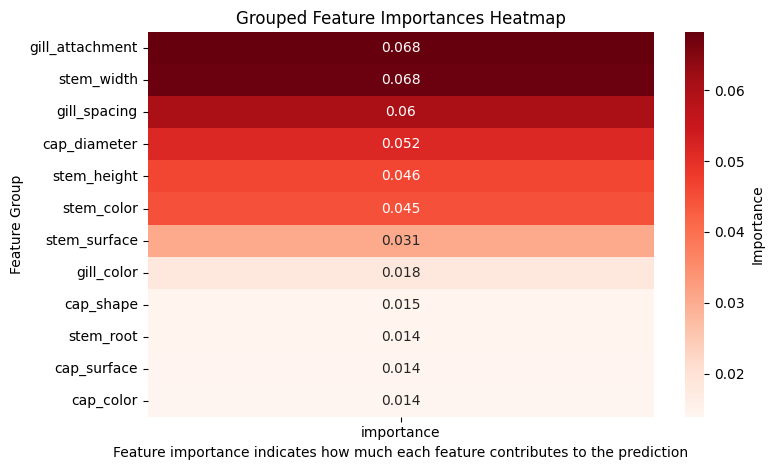

In [100]:
# Example df_feature_importances DataFrame with columns: 'feature' and 'importance'
# Your feature names look like 'stem_color_52', 'gill_spacing_3', etc.

# Step 1: Extract base feature names (everything before last underscore if numeric suffix exists)
def extract_base_feature(name):
    parts = name.rsplit('_', 1)
    # If last part is a number, remove it to get base feature name
    if parts[-1].isdigit():
        return parts[0]
    else:
        return name

df_feature_importances['base_feature'] = df_feature_importances['feature'].apply(extract_base_feature)

# Step 2: Group by base feature and sum importances
grouped_importance = df_feature_importances.groupby('base_feature')['importance'].sum().reset_index()

# Step 3: Sort by importance descending
grouped_importance = grouped_importance.sort_values('importance', ascending=False)

# Step 4: Create heatmap data (reshape for heatmap, here just one column)
heatmap_data = grouped_importance.set_index('base_feature')

plt.figure(figsize=(8, max(4, len(heatmap_data) * 0.4)))
sns.heatmap(heatmap_data, annot=True, cmap='Reds', cbar_kws={'label': 'Importance'})
plt.title('Grouped Feature Importances Heatmap')
plt.xlabel('Feature importance indicates how much each feature contributes to the prediction')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()


In [114]:
# Create mapping from generic feature names (e.g., feature_0) to actual names
feature_mapping = {f'feature_{i}': name for i, name in enumerate(feature_names)}

# Print mapping
for key, value in feature_mapping.items():
    print(f"{key}: {value}")

feature_0: cap_diameter
feature_1: stem_height
feature_2: stem_width
feature_3: cap_shape_0
feature_4: cap_shape_1
feature_5: cap_shape_2
feature_6: cap_shape_3
feature_7: cap_shape_4
feature_8: cap_shape_5
feature_9: cap_shape_6
feature_10: cap_shape_7
feature_11: cap_shape_8
feature_12: cap_shape_9
feature_13: cap_shape_10
feature_14: cap_shape_11
feature_15: cap_shape_12
feature_16: cap_shape_13
feature_17: cap_shape_14
feature_18: cap_shape_15
feature_19: cap_shape_16
feature_20: cap_shape_17
feature_21: cap_shape_18
feature_22: cap_shape_19
feature_23: cap_shape_20
feature_24: cap_shape_21
feature_25: cap_shape_22
feature_26: cap_shape_23
feature_27: cap_shape_24
feature_28: cap_shape_25
feature_29: cap_shape_26
feature_30: cap_shape_27
feature_31: cap_shape_28
feature_32: cap_shape_29
feature_33: cap_shape_30
feature_34: cap_shape_31
feature_35: cap_shape_32
feature_36: cap_shape_33
feature_37: cap_surface_0
feature_38: cap_surface_1
feature_39: cap_surface_2
feature_40: cap_surf

Logistic Regression with 'feature_2' — Accuracy: 0.5167


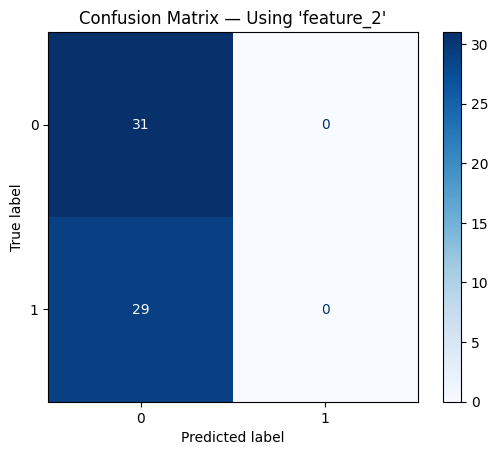

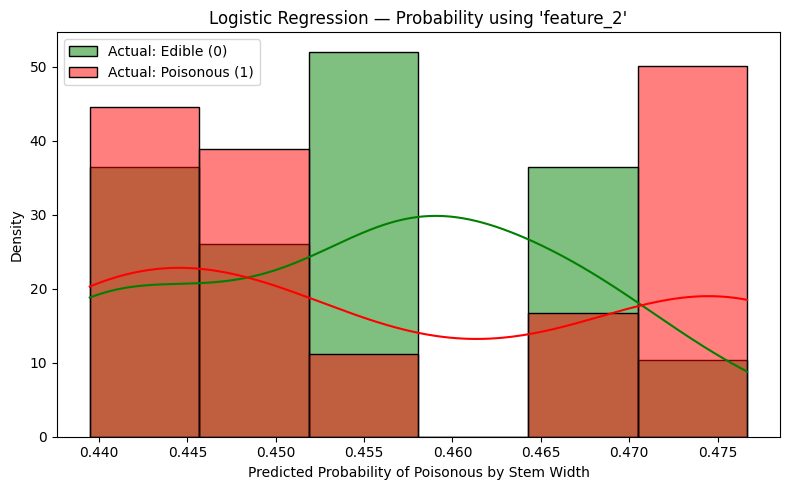

In [118]:
# 1. Replace -1 with NaN
df_encoded = df_encoded.replace(-1, np.nan)

# 2. Fill missing values with mode (most frequent)
df_filled = df_encoded.fillna(df_encoded.mode().iloc[0])

# 🔹 Choose only one important feature
selected_feature = 'feature_2'  # You can replace this with 'cap_diameter', etc.

# 3. Separate selected feature and target
X = df_filled[[selected_feature]]  # Double brackets for DataFrame shape
y = df_filled['class']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Make predictions and evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of being poisonous

accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression with '{selected_feature}' — Accuracy: {accuracy:.4f}")

# 7. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix — Using '{selected_feature}'")
plt.show()

# 8. Plot predicted probabilities
plt.figure(figsize=(8, 5))
sns.histplot(y_proba[y_test == 0], label="Actual: Edible (0)", color='green', kde=True, stat='density')
sns.histplot(y_proba[y_test == 1], label="Actual: Poisonous (1)", color='red', kde=True, stat='density')
plt.title(f"Logistic Regression — Probability using '{selected_feature}'")
plt.xlabel("Predicted Probability of Poisonous by Stem Width")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
